<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Projeto Proposto 
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> Este projeto baseia-se na criação de um Modelo de Regressão para Previsão do Consumo de Energia. </i>       
</p>  

# <font color='red' style='font-size: 40px;'> Problemática </font>
<hr style='border: 2px solid red;'>

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i>  Este projeto tem o intuito de ser um Modelo de Machine Learning para prever o consumo de eletricidade com base em metadados de construção, utilizando histórico e dados meteorológicos. O conjunto de dados inclui leituras de medidores por hora de 100 edifícios em vários locais diferentes ao redor do mundo.


</i> 
</p>  

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> 
</i> 
</p>  


https://www.kaggle.com/competitions/predicting-electricity-consumption/data


# <font color='red' style='font-size: 40px;'> Bibliotecas Utilizadas </font>
<hr style='border: 2px solid red;'>

In [1]:
## Bibliotecas De Manipulação de Dados e Visualização
import pandas as pd 
import builtins as builtins
from pyspark.sql.functions import * 
from pyspark.sql.window import Window
from pyspark.sql import SparkSession, Row, functions as F 
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import display, Image

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, kruskal
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.diagnostic import lilliefors

# Bibliotecas de Manipulação de Tempo
import time
import datetime

# Bibiliotecas de Seleção de Modelos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer 
from sklearn.feature_selection import RFE, VarianceThreshold
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection

# Bibliotecas de Pré-Processamento e Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder, BinaryEncoder
import category_encoders as ce 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer

# Bibliotecas de Modelos de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Bibliotecas de Métricas de Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Parâmetros de Otimização
import warnings
%matplotlib inline
sns.set()
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings

# Spark Session
spark = SparkSession.builder.appName('Model_Energy_Predict').getOrCreate()

# <font color='red' style='font-size: 40px;'> Funções </font>
<hr style='border: 2px solid red;'>

## Funções de Visualização

* Plota Barras 

In [2]:
def plota_barras(lista_variaveis, hue, df, linhas, colunas, titulo):
    if hue != False:
        if (linhas == 1) and (colunas == 1):
            k = 0
            ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', hue = hue)
            ax.set_title(f'{titulo}')
            ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
            ax.set_ylabel(f'Quantidade', fontsize = 14)
            total = []
            for bar in ax.patches:
                height = bar.get_height()
                total.append(height)
            total = builtins.sum(total)
            
            sizes = []
            for bar in ax.patches:
                height = bar.get_height()
                sizes.append(height)
                ax.text(bar.get_x() + bar.get_width()/1.6,
                        height,
                        f'{builtins.round((height/total)*100, 2)}%',
                        ha = 'center',
                        fontsize = 12
                )
            ax.set_ylim(0, builtins.max(sizes)*1.1)
            plt.show()
        elif linhas == 1:
            fig, axis = plt.subplots(linhas, colunas, figsize=(20, 10), sharey=True)
            fig.suptitle(f'{titulo}')
            k = 0
            for i in np.arange(linhas):
                for j in np.arange(colunas):
                    ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', ax = axis[j], hue = hue)
                    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                    ax.set_ylabel(f'Quantidade', fontsize = 14)
                    total = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        total.append(height)
                    total = builtins.sum(total)
                    
                    sizes = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        sizes.append(height)
                        ax.text(bar.get_x() + bar.get_width()/1.6,
                                height,
                                f'{builtins.round((height/total)*100, 2)}%',
                                ha = 'center',
                                fontsize = 12
                        )
                    ax.set_ylim(0, builtins.max(sizes)*1.1)
                    k = k + 1
        elif colunas == 1:
            fig, axis = plt.subplots(linhas, colunas, figsize=(20, 10), sharey=True)
            fig.suptitle(f'{titulo}')
            k = 0
            for i in np.arange(linhas):
                for j in np.arange(colunas):
                    ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', ax = axis[i], hue = hue)
                    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                    ax.set_ylabel(f'Quantidade', fontsize = 14)
                    total = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        total.append(height)
                    total = builtins.sum(total)
                    
                    sizes = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        sizes.append(height)
                        ax.text(bar.get_x() + bar.get_width()/1.6,
                                height,
                                f'{builtins.round((height/total)*100, 2)}%',
                                ha = 'center',
                                fontsize = 12
                        )
                    ax.set_ylim(0, builtins.max(sizes)*1.1)
                    k = k + 1
        else: 
            fig, axis = plt.subplots(linhas, colunas, figsize=(20, 10), sharey=True)
            fig.suptitle(f'{titulo}')
            k = 0
            for i in np.arange(linhas):
                for j in np.arange(colunas):
                    ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', ax = axis[i, j], hue = hue)
                    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                    ax.set_ylabel(f'Quantidade', fontsize = 14)
                    total = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        total.append(height)
                    total = builtins.sum(total)
                    
                    sizes = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        sizes.append(height)
                        ax.text(bar.get_x() + bar.get_width()/1.6,
                                height,
                                f'{builtins.round((height/total)*100, 2)}%',
                                ha = 'center',
                                fontsize = 12
                        )
                    ax.set_ylim(0, builtins.max(sizes)*1.1)
                    k = k + 1
    else:
        if (linhas == 1) and (colunas == 1):
            k = 0
            ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', color='#1FB3E5')
            ax.set_title(f'{titulo}')
            ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
            ax.set_ylabel(f'Quantidade', fontsize = 14)
            total = []
            for bar in ax.patches:
                height = bar.get_height()
                total.append(height)
            total = builtins.sum(total)
            
            sizes = []
            for bar in ax.patches:
                height = bar.get_height()
                sizes.append(height)
                ax.text(bar.get_x() + bar.get_width()/1.6,
                        height,
                        f'{builtins.round((height/total)*100, 2)}%',
                        ha = 'center',
                        fontsize = 12
                )
            ax.set_ylim(0, builtins.max(sizes)*1.1)
            plt.show()

        elif linhas == 1:
            fig, axis = plt.subplots(linhas, colunas, figsize=(20, 10), sharey=True)
            fig.suptitle(f'{titulo}')
            k = 0
            for i in np.arange(linhas):
                for j in np.arange(colunas):
                    ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', ax = axis[j], color='#1FB3E5')
                    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                    ax.set_ylabel(f'Quantidade', fontsize = 14)
                    total = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        total.append(height)
                    total = builtins.sum(total)
                    
                    sizes = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        sizes.append(height)
                        ax.text(bar.get_x() + bar.get_width()/1.6,
                                height,
                                f'{builtins.round((height/total)*100, 2)}%',
                                ha = 'center',
                                fontsize = 12
                        )
                    ax.set_ylim(0, builtins.max(sizes)*1.1)
                    k = k + 1
        elif colunas == 1:
            fig, axis = plt.subplots(linhas, colunas, figsize=(20, 10), sharey=True)
            fig.suptitle(f'{titulo}')
            k = 0
            for i in np.arange(linhas):
                for j in np.arange(colunas):
                    ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', ax = axis[i], color='#1FB3E5')
                    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                    ax.set_ylabel(f'Quantidade', fontsize = 14)
                    total = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        total.append(height)
                    total = builtins.sum(total)
                    
                    sizes = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        sizes.append(height)
                        ax.text(bar.get_x() + bar.get_width()/1.6,
                                height,
                                f'{builtins.round((height/total)*100, 2)}%',
                                ha = 'center',
                                fontsize = 12
                        )
                    ax.set_ylim(0, builtins.max(sizes)*1.1)
                    k = k + 1
        else:
            fig, axis = plt.subplots(linhas, colunas, figsize=(20, 10), sharey=True)
            fig.suptitle(f'{titulo}')
            k = 0
            for i in np.arange(linhas):
                for j in np.arange(colunas):
                    ax = sns.countplot(x = lista_variaveis[k], data = df, orient = 'h', ax = axis[i, j], color='#1FB3E5')
                    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                    ax.set_ylabel(f'Quantidade', fontsize = 14)
                    total = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        total.append(height)
                    total = builtins.sum(total)
                    
                    sizes = []
                    for bar in ax.patches:
                        height = bar.get_height()
                        sizes.append(height)
                        ax.text(bar.get_x() + bar.get_width()/1.6,
                                height,
                                f'{builtins.round((height/total)*100, 2)}%',
                                ha = 'center',
                                fontsize = 12
                        )
                    ax.set_ylim(0, builtins.max(sizes)*1.1)
                    k = k + 1


* Plota Histogramas 

In [3]:
def plota_histograma(lista_variaveis, df, linhas, colunas, titulo):
    if (linhas == 1) and (colunas == 1): 
        k = 0
        mediana = df[lista_variaveis[k]].median()
        media = df[lista_variaveis[k]].mean().round()
        plt.figure(figsize = (14, 4))
        ax = sns.histplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', bins = 30)
        ax.set_title(f'{titulo}')
        ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
        ax.set_ylabel(f'Frequência', fontsize = 14)
        ax.axvline(x = mediana, ymax = 0.75 ,color = '#231F20', linestyle = '-', label = f'mediana = {mediana}')
        ax.axvline(x = media, ymax = 0.75,color = '#231F20', linestyle = '--', label = f'media = {media}')
        plt.ticklabel_format(style='plain')
        plt.legend(loc = 'best')
        plt.show()
    elif linhas == 1:
        fig, axis = plt.subplots(linhas, colunas, figsize = (14, 4), sharey = True)
        fig.suptitle(f'{titulo}')
        k = 0
        for i in np.arange(linhas):
            for j in np.arange(colunas):
                mediana = df[lista_variaveis[k]].median()
                media = df[lista_variaveis[k]].mean().round()
                ax = sns.histplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', ax = axis[j], bins = 30)
                ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                ax.set_ylabel(f'Frequência', fontsize = 14)
                ax.axvline(x = mediana, ymax = 0.75 ,color = '#231F20', linestyle = '-', label = f'mediana = {mediana}')
                ax.axvline(x = media, ymax = 0.75,color = '#231F20', linestyle = '--', label = f'media = {media}')
                ax.ticklabel_format(style='plain')
                ax.legend(loc = 'best')
                k = k + 1
    elif colunas == 1:
        fig, axis = plt.subplots(linhas, colunas, figsize = (14, 4), sharey = True)
        fig.suptitle(f'{titulo}')
        k = 0
        for i in np.arange(linhas):
            for j in np.arange(colunas):
                mediana = df[lista_variaveis[k]].median()
                media = df[lista_variaveis[k]].mean().round()
                ax = sns.histplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', ax = axis[i], bins = 30)
                ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                ax.set_ylabel(f'Frequência', fontsize = 14)
                ax.axvline(x = mediana, ymax = 0.75 ,color = '#231F20', linestyle = '-', label = f'mediana = {mediana}')
                ax.axvline(x = media, ymax = 0.75,color = '#231F20', linestyle = '--', label = f'media = {media}')
                ax.ticklabel_format(style='plain')
                ax.legend(loc = 'best')
                k = k + 1
    else:
        fig, axis = plt.subplots(linhas, colunas, figsize = (14, 4), sharey = True)
        fig.suptitle(f'{titulo}')
        k = 0
        for i in np.arange(linhas):
            for j in np.arange(colunas):
                mediana = df[lista_variaveis[k]].median()
                media = df[lista_variaveis[k]].mean().round()
                ax = sns.histplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', ax = axis[i, j], bins = 30)
                ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                ax.set_ylabel(f'Frequência', fontsize = 14)
                ax.axvline(x = mediana, ymax = 0.75 ,color = '#231F20', linestyle = '-', label = f'mediana = {mediana}')
                ax.axvline(x = media, ymax = 0.75,color = '#231F20', linestyle = '--', label = f'media = {media}')
                ax.ticklabel_format(style='plain')
                ax.legend(loc = 'best')
                k = k + 1

* Plota Boxplot

In [4]:
def plota_boxplot(lista_variaveis, df, linhas, colunas, titulo):
    if (linhas == 1) and (colunas == 1): 
        k = 0
        plt.figure(figsize = (14, 4))
        ax = sns.boxplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', orient = 'h')
        ax.set_title(f'{titulo}')
        ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
        ax.set_ylabel(f'Frequência', fontsize = 14)
        plt.show()
    elif linhas == 1:
        fig, axis = plt.subplots(linhas, colunas, figsize = (14, 4), sharey = True)
        k = 0
        for i in np.arange(linhas):
            for j in np.arange(colunas):
                ax = sns.boxplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', ax = axis[j], orient = 'h')
                ax.set_title(f'{titulo}')
                ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                ax.set_ylabel(f'Frequência', fontsize = 14)
                k = k + 1
    elif colunas == 1:
        fig, axis = plt.subplots(linhas, colunas, figsize = (14, 4), sharey = True)
        k = 0
        for i in np.arange(linhas):
            for j in np.arange(colunas):
                ax = sns.boxplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', ax = axis[i], orient = 'h')
                ax.set_title(f'{titulo}')
                ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                ax.set_ylabel(f'Frequência', fontsize = 14)
                k = k + 1
    else:
        fig, axis = plt.subplots(linhas, colunas, figsize = (14, 4), sharey = True)
        k = 0
        for i in np.arange(linhas):
            for j in np.arange(colunas):
                ax = sns.boxplot(x = lista_variaveis[k], data = df, color = '#1FB3E5', ax = axis[i, j], orient = 'h')
                ax.set_title(f'{titulo}')
                ax.set_xlabel(f'{lista_variaveis[k]}', fontsize = 14)
                ax.set_ylabel(f'Frequência', fontsize = 14)
                k = k + 1

* Plota Dispersão

In [5]:
def plota_dispersao(df, titulo,  x, y, metodo):
    plt.figure(figsize = (10, 5))
    sns.set(style = 'whitegrid')
    corr1 = str(df[[x, y]].corr(method = metodo).iloc[1, 0].round(2))
    sns.scatterplot(data = df, x = x, y = y, color = '#1FB3E5', sizes = 1, alpha = 0.50, marker = '.')
    plt.text(1, 1, f'Correlacao: {corr1}', fontsize = 12)
    plt.title(f'{titulo}', fontsize = 14)
    plt.xlabel(f'{x}', fontsize = 14)
    plt.ylabel(f'{y}', fontsize = 14)
    plt.ticklabel_format(style = 'plain')
    plt.grid(True, linestyle=':')
    sns.despine()
    plt.tight_layout()
    plt.show()

- Plota Série Temporal

In [6]:
def plota_temporal(df, titulo, x, y):
    plt.figure(figsize=(10, 6))
    plt.plot(df_train_time_series, color='#1FB3E5', linewidth=2)
    plt.scatter(df_train_time_series.index, df_train_time_series, color='#1FB3E5', s=40)
    plt.title(f"{titulo}", fontsize=14)  # Define o título do gráfico e o tamanho da fonte
    plt.xlabel(f"{x}", fontsize=12)  # Define o rótulo do eixo x e o tamanho da fonte
    plt.ylabel(f"{y}", fontsize=12)  # Define o rótulo do eixo y e o tamanho da fonte
    plt.xticks(df_train_time_series.index, fontsize=10)  # Define o tamanho da fonte dos valores no eixo x
    plt.yticks(fontsize=10)  # Define o tamanho da fonte dos valores no eixo y
    plt.grid(True, linestyle=':', alpha=0.5)  # Adiciona linhas de grade
    plt.tight_layout()  # Ajusta automaticamente a posição dos elementos do gráfico
    plt.show()  # Exibe o gráfico

## Funções de Estatística

* Analisa Correlação

In [7]:
def analisa_correlacao(metodo, df):
    plt.figure(figsize = (10, 5))
    sns.heatmap(df.corr(method = metodo), vmin = -1, vmax = 1, cmap = 'magma', annot = True)
    plt.title(f"Analisando Correlação de {metodo}")
    plt.grid(False)
    plt.box(False)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

* Analisa Normalidade 

In [8]:
def analisa_normalidade(amostra1, amostra2, variavel):

    normaltest_amostra_1 = normaltest(amostra1[variavel])
    normaltest_amostra_2 = normaltest(amostra2[variavel])

    if (normaltest_amostra_1[1] < 0.05 ) and (normaltest_amostra_2[1] < 0.05):
        print(f'Pelo Teste de Hipótese, A Hipótese Nula de que a variável "{variavel}" segue uma Distribuição Normal é REJEITADA!')
    else:
        print(f'Pelo Teste de Hipótese, A Hipótese Nula de  que a variável "{variavel}" segue uma Distribuição Normal é ACEITA')

    ax1 = plt.subplot(121)
    stats.probplot(amostra1[variavel], dist = 'norm', plot = plt)
    plt.title(f'Amostra 1', fontsize = 14)
    plt.grid(False)
    plt.box(False)
    plt.tight_layout()
    ax1 = plt.subplot(122)
    stats.probplot(amostra2[variavel], dist = 'norm', plot = plt)
    plt.title(f'Amostra 2', fontsize = 14)
    plt.grid(False)
    plt.box(False)
    plt.tight_layout()

    
    plt.show()



* Teste de Hipótese para Duas Amostras Independentes 

In [9]:
def teste_hipotese_duas_amostras_independentes(parametrico, amostra1, amostra2, variavel):
    media_amostra_1 = amostra1[variavel].mean()
    media_amostra_2 = amostra2[variavel].mean()
    mediana_amostra_1 = amostra1[variavel].median()
    mediana_amostra_2 = amostra2[variavel].median()

    if parametrico == True: 
        print(f'Média Amostra 1: {media_amostra_1}')
        print(f'Média Amostra 2: {media_amostra_2}')
        stat, p_value = ztest(amostra1[variavel], amostra2[variavel]) 
        if p_value > 0.05:
            print(f'Pelo Teste de Hipótese Z, não há diferença significativa entre as médias da Amostra 1 e Amostra 2')
        else:
            print(f'Pelo Teste de Hipótese Z, há diferença significativa entre as médias da Amostra 1 e Amostra 2')
    else:
        print(f'Mediana Amostra 1: {mediana_amostra_1}')
        print(f'Mediana Amostra 2: {mediana_amostra_2}')
        stat, p_value = stats.mannwhitneyu(amostra1[variavel], amostra2[variavel]) 
        if p_value > 0.05:
            print(f'Pelo Teste de Hipótese de Mann Whitney, não há diferença significativa entre as medianas da Amostra 1 e Amostra 2')
        else:
            print(f'Pelo Teste de Hipótese de Mann Whitney, há diferença significativa entre as medianas da Amostra 1 e Amostra 2')

- Teste de Hipótese para Muitas Amostras Independentes 

In [10]:
def teste_hipotese_muitas_amostras_independentes(amostras, variavel):
    medianas = []
    
    for i, amostra in enumerate(amostras):
        mediana_amostra = amostra[variavel].median()
        medianas.append(mediana_amostra)
        print(f'Mediana Amostra {i+1}: {mediana_amostra}')

    stat, p_value = kruskal(*[amostra[variavel] for amostra in amostras])
    
    if p_value > 0.05:
        print(f'Pelo teste de Kruskal-Wallis, não há diferença significativa entre as medianas das amostras')
    else:
        print(f'Pelo teste de Kruskal-Wallis, há diferença significativa entre as medianas das amostras')


## Funções de Pré-Processamento

- Cria features de tempo

In [11]:
def features_temporais(train, test):
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])


    train['year'] = train['timestamp'].dt.year
    train['month'] = train['timestamp'].dt.month
    train['day'] = train['timestamp'].dt.day
    train['hour'] = train['timestamp'].dt.hour

    test['year'] = test['timestamp'].dt.year
    test['month'] = test['timestamp'].dt.month
    test['day'] = test['timestamp'].dt.day
    test['hour'] = test['timestamp'].dt.hour

* Separa entre Features e Target 

In [12]:
def separa_feature_target(target, dados):
    x = dados.drop(target, axis = 1)
    y = dados[[target]]
    return x, y

- Separa entre Treino e Teste 

In [13]:
def separa_treino_teste_temporal(data, data_teste, dados):
    dados.sort_values(by = data, ascending = True, inplace = True)
    df_train = dados.loc[dados[data] < data_teste]
    df_test = dados.loc[dados[data] >= data_teste]

    return df_train, df_test

## Funções de Métricas ou Avaliação 

In [14]:
def metricas(regressor, target, y_train, y_predict_train, y_test, y_predict_test, coeficiente_det_train, coeficiente_det_test):
    y_test[target].fillna(y_train[target].median(), inplace = True)

    mae_train = mean_absolute_error(y_predict_train, y_train)
    mse_train = mean_squared_error(y_predict_train, y_train)
    mape_train = mean_absolute_percentage_error(y_predict_train, y_train)
    metricas_treino = pd.DataFrame({'Coeficiente de Determinação (R^2)':coeficiente_det_train, 'Erro_Medio_Absoluto':mae_train, 'Erro_Quadratico_Medio':mse_train, 'Media_Percentual_Absoluta_Erro':mape_train, 'Etapa':'treino', 'Regressor':regressor}, index = np.arange(1, 2))


    mae_test = mean_absolute_error(y_predict_test, y_test)
    mse_test = mean_squared_error(y_predict_test, y_test)
    mape_test = mean_absolute_percentage_error(y_predict_test, y_test)
    metricas_teste = pd.DataFrame({'Coeficiente de Determinação (R^2)':coeficiente_det_test, 'Erro_Medio_Absoluto':mae_test, 'Erro_Quadratico_Medio':mse_test, 'Media_Percentual_Absoluta_Erro':mape_test, 'Etapa':'teste', 'Regressor':regressor}, index = np.arange(1, 2))

    metricas_finais = pd.concat([metricas_treino, metricas_teste])

    return metricas_finais

def metricas_modelos_juntos(lista_modelos):
    metricas_modelos = pd.concat(lista_modelos).set_index('Regressor')
    return metricas_modelos


* Validação Cruzada 

In [15]:
def validacao_cruzada_regressao(target_type, x_train, y_train, n_splits, regressor):
    categoricas = [column for column in x_train.columns if x_train[column].dtype.name == 'object']
    numericas = [column for column in x_train.columns if (x_train[column].dtype.name == 'int64') or (x_train[column].dtype.name == 'float64')]
    
    pipeline_categoricas = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', BinaryEncoder(handle_unknown='ignore', sparse=False))
    ])
    
    pipeline_numericas = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])
    
    pre_processamento = ColumnTransformer([
        ('cat', pipeline_categoricas, categoricas),
        ('num', pipeline_numericas, numericas)
    ])
    
    if target_type == 'categorico':
        y_train.fillna(y_train.mode()[0], inplace=True)
    else:
        y_train.fillna(y_train.median(), inplace=True)
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    if regressor == 'Regressão Linear Múltipla':
        model = make_pipeline(pre_processamento, LinearRegression())
    elif regressor == 'Random Forest':
        model = make_pipeline(pre_processamento, RandomForestRegressor(n_estimators=100, max_depth=9, criterion='squared_error', random_state=42))
    elif regressor == 'Gradient Boosting':
        model = make_pipeline(pre_processamento, GradientBoostingRegressor(n_estimators=100, max_depth=9, loss='ls', random_state=42))
    else:
        print('Utilize Regressão Linear Múltipla, Random Forest ou Gradient Boosting como opções de Regressores!')
    
    coef_det = cross_val_score(model, x_train, y_train, cv=kfold, scoring='r2').mean()
    mae = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_absolute_error').mean()
    mse = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error').mean()
    mape = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_absolute_percentage_error').mean()
    
    metricas_finais = pd.DataFrame({'Coeficiente de Determinação (R^2)': coef_det,
                                    'Erro_Medio_Absoluto': mae * -1,
                                    'Erro_Quadratico_Medio': mse * -1,
                                    'Media_Percentual_Absoluta_Erro': mape * -1,
                                    'Etapa': 'validacao_cruzada',
                                    'Regressor': regressor}, index=np.arange(1, 2))
    
    return metricas_finais


## Funções de Machine Learning 

In [16]:
def regressao_linear_multipla(target_type, x_train, y_train, x_test, y_test, otimizacao, numero_features, regularization=None):
    categoricas = [column for column in x_train.columns if x_train[column].dtype.name == 'object']
    numericas = [column for column in x_train.columns if (x_train[column].dtype.name == 'int64') or (x_train[column].dtype.name == 'float64')]
    pipeline_categoricas = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', BinaryEncoder())
    ])
    pipeline_numericas = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
    ])
    pre_processamento = ColumnTransformer([
        ('cat', pipeline_categoricas, categoricas),
        ('num', pipeline_numericas, numericas)
    ])
    if target_type == 'categorico':
        y_train.fillna(y_train.mode(), inplace=True)
        y_test.fillna(y_train.mode(), inplace=True)
    else:
        y_train.fillna(y_train.median(), inplace=True)
        y_test.fillna(y_train.median(), inplace=True)
    if otimizacao:
        if regularization == 'Lasso':
            model = make_pipeline(pre_processamento, RFE(Lasso(), step=1, n_features_to_select=numero_features))
        elif regularization == 'Ridge':
            model = make_pipeline(pre_processamento, RFE(Ridge(), step=1, n_features_to_select=numero_features))
        else:
            model = make_pipeline(pre_processamento, RFE(LinearRegression(), step=1, n_features_to_select=numero_features))
    else:
        model = make_pipeline(pre_processamento, LinearRegression())
    model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    coef_det_train = round(model.score(x_train, y_train), 2)
    coef_det_test = round(model.score(x_test, y_test), 2)
    return y_predict_train, y_predict_test, coef_det_train, coef_det_test

In [17]:
def regressao_random_forest(target_type, x_train, y_train, x_test, y_test, otimizacao, numero_features):
    categoricas = [column for column in x_train.columns if x_train[column].dtype.name == 'object']
    numericas = [column for column in x_train.columns if (x_train[column].dtype.name == 'int64') or (x_train[column].dtype.name == 'float64')]
    pipeline_categoricas = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', BinaryEncoder())
    ])
    pipeline_numericas = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
    ])
    pre_processamento = ColumnTransformer([
        ('cat', pipeline_categoricas, categoricas),
        ('num', pipeline_numericas, numericas)
    ])
    if target_type == 'categorico':
        y_train.fillna(y_train.mode(), inplace=True)
        y_test.fillna(y_train.mode(), inplace=True)
    else:
        y_train.fillna(y_train.median(), inplace=True)
        y_test.fillna(y_train.median(), inplace=True)
    model = make_pipeline(pre_processamento, RandomForestRegressor(n_estimators=100, max_depth=9, random_state=42))
    model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    coef_det_train = round(model.score(x_train, y_train), 2)
    coef_det_test = round(model.score(x_test, y_test), 2)

    # Seleção de recursos com base na importância das características
    importances = model.named_steps['randomforestregressor'].feature_importances_
    indices = np.argsort(importances)[::-1]  # Ordenar índices em ordem decrescente
    features_selecionadas = x_train.columns[indices][:numero_features]
    x_train_selecionado = x_train[features_selecionadas]
    x_test_selecionado = x_test[features_selecionadas]

    return y_predict_train, y_predict_test, coef_det_train, coef_det_test, importances, indices, features_selecionadas


In [18]:
def regressao_gradient_boosting(target_type, x_train, y_train, x_test, y_test, otimizacao, numero_features):
    categoricas = [column for column in x_train.columns if x_train[column].dtype.name == 'object']
    numericas = [column for column in x_train.columns if (x_train[column].dtype.name == 'int64') or (x_train[column].dtype.name == 'float64')]
    pipeline_categoricas = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', BinaryEncoder())
    ])
    pipeline_numericas = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
    ])
    pre_processamento = ColumnTransformer([
        ('cat', pipeline_categoricas, categoricas),
        ('num', pipeline_numericas, numericas)
    ])
    if target_type == 'categorico':
        y_train.fillna(y_train.mode(), inplace=True)
        y_test.fillna(y_train.mode(), inplace=True)
    else:
        y_train.fillna(y_train.median(), inplace=True)
        y_test.fillna(y_train.median(), inplace=True)
    model = make_pipeline(pre_processamento, GradientBoostingRegressor(n_estimators=100, max_depth=9, loss='ls', random_state=42))
    model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    coef_det_train = round(model.score(x_train, y_train), 2)
    coef_det_test = round(model.score(x_test, y_test), 2)

    # Seleção de recursos com base na importância das características
    importances = model.named_steps['gradientboostingregressor'].feature_importances_
    indices = np.argsort(importances)[::-1]  # Ordenar índices em ordem decrescente
    features_selecionadas = x_train.columns[indices][:numero_features]
    x_train_selecionado = x_train[features_selecionadas]
    x_test_selecionado = x_test[features_selecionadas]

    return y_predict_train, y_predict_test, coef_det_train, coef_det_test, importances, indices, features_selecionadas


# <font color='red' style='font-size: 40px;'> 1) Entendimento da Base de Dados </font>
<hr style='border: 2px solid red;'>

## 1.1) Descrição das Variáveis

> 1. 'building_id' : ID da Residência

> 2. 'timestamp' : Quando a medição foi feita.

> 3. 'meter_reading': A variável de destino. Consumo de energia em kWh. (Target)

> 4. 'primary_use':  Indicador da categoria principal de atividades para o edifício com base nas definições de tipo de propriedade EnergyStar.

> 5. 'square_feet': Área bruta do edifício.

> 6. 'year_built': Edifício do ano em que foi inaugurado.

> 7. 'air_temperature': Graus Celsius.

> 8. 'cloud_coverage': Porção do céu coberta por nuvens, em octas.

> 9. 'dew_temperature': Graus Celsius

> 10. 'precip_depth_1_hr': Milímetros

> 11. 'sea_level_pressure': Pressão

> 12. 'wind_direction': Direção do Vento

> 13. 'wind_speed': Velocidade do Vento


## 1.2) Informações Inicais

In [19]:
train = pd.read_csv('../04_modelo_predicao_consumo_energia/data/train.csv')
test = pd.read_csv('../04_modelo_predicao_consumo_energia/data/test.csv')
print(f'Quantidade de Casas Treino: {train.building_id.nunique()}')
print(f'Quantidade de Casas Teste: {test.building_id.nunique()}')

Quantidade de Casas Treino: 101
Quantidade de Casas Teste: 101


In [20]:
print(f'Tamanho da Base de Treino: {train.shape[0]}')
print(f'Tamanho da Base de Teste: {test.shape[0]}')

df_nulls_train = pd.DataFrame(train.isnull().sum()).reset_index().rename({'index':'features', 0:'quantidade_nulos_treino'}, axis = 1)
df_nulls_test = pd.DataFrame(test.isnull().sum()).reset_index().rename({'index':'features', 0:'quantidade_nulos_teste'}, axis = 1)
df_null = df_nulls_train.merge(df_nulls_test, on = 'features', how = 'left')
df_null

Tamanho da Base de Treino: 639119
Tamanho da Base de Teste: 14944


,features,quantidade_nulos_treino,quantidade_nulos_teste
0,building_id,0,0.00
1,timestamp,0,0.00
2,meter_reading,0,NaN
3,primary_use,0,0.00
4,square_feet,0,0.00
5,year_built,0,0.00
6,air_temperature,223,0.00
7,cloud_coverage,281915,5738.00
8,dew_temperature,223,0.00
9,precip_depth_1_hr,84,0.00


# <font color='red' style='font-size: 40px;'> 2.0 Análise Exploratória </font>
<hr style='border: 2px solid red;'>

## 2.1) Separando em Treino e Validação



In [21]:
df_train = separa_treino_teste_temporal('timestamp', '2016-11-01', train)[0]
df_valid = separa_treino_teste_temporal('timestamp', '2016-11-01', train)[1]

print(f'Quantidade de Casas Treino: {df_train.building_id.nunique()}')
print(f'Quantidade de Casas Validação: {df_valid.building_id.nunique()}')

Quantidade de Casas Treino: 101
Quantidade de Casas Validação: 101


In [22]:
features_temporais(df_train, df_valid)

display(df_train.head())
display(df_valid.head())

,building_id,timestamp,meter_reading,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour
298388,47,2016-01-01,0.00,Retail,31666,2008,25.00,6.00,20.00,NaN,1019.70,0.00,0.00,2016,1,1,0
116005,18,2016-01-01,0.00,Education,111891,1996,25.00,6.00,20.00,NaN,1019.70,0.00,0.00,2016,1,1,0
504200,80,2016-01-01,0.00,Office,156111,2001,25.00,6.00,20.00,NaN,1019.70,0.00,0.00,2016,1,1,0
122515,19,2016-01-01,0.00,Office,18717,2004,25.00,6.00,20.00,NaN,1019.70,0.00,0.00,2016,1,1,0
497751,79,2016-01-01,0.00,Office,36240,2010,25.00,6.00,20.00,NaN,1019.70,0.00,0.00,2016,1,1,0


,building_id,timestamp,meter_reading,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour
221115,34,2016-11-01,310.43,Lodging/residential,42731,2002,23.30,2.00,18.30,0.00,1018.10,60.00,3.60,2016,11,1,0
420046,66,2016-11-01,180.60,Lodging/residential,37241,1981,23.30,2.00,18.30,0.00,1018.10,60.00,3.60,2016,11,1,0
426427,67,2016-11-01,189.48,Lodging/residential,24456,1968,23.30,2.00,18.30,0.00,1018.10,60.00,3.60,2016,11,1,0
50946,7,2016-11-01,500.66,Education,121074,1989,23.30,2.00,18.30,0.00,1018.10,60.00,3.60,2016,11,1,0
18767,2,2016-11-01,12.70,Education,5376,1991,23.30,2.00,18.30,0.00,1018.10,60.00,3.60,2016,11,1,0


> 1. Inicialmente, deve-se separar em Dados de Treino e Dados de Teste para evitar Data Leakage, ou seja, evitar que as informações do teste vazem para o treino

## 2.2) Análise Univariada e Bivariada - Variáveis Contínuas

###  A) Como é o comportamento da Distribuição da Target (meter_reading)?

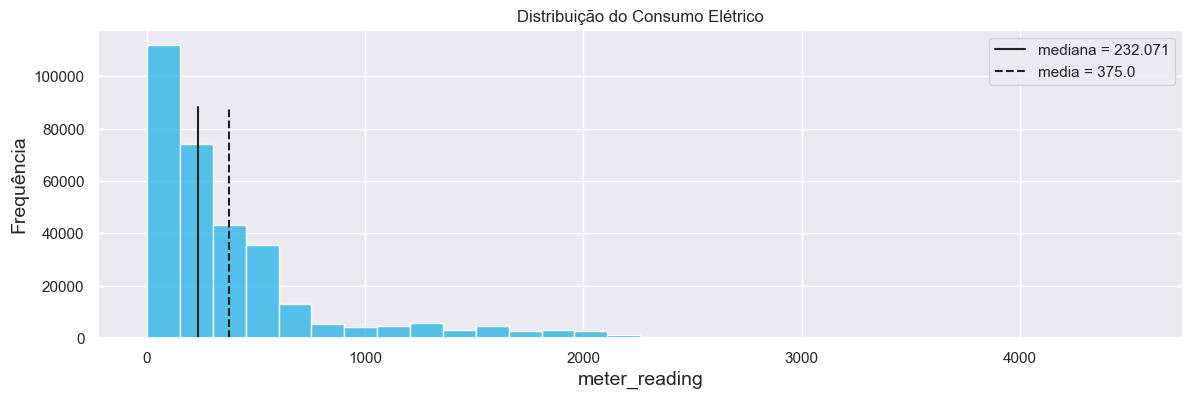

In [23]:
plota_histograma(
    ['meter_reading'],
    df_train.loc[df_train['meter_reading'] > 0], 
    1,
    1,
    'Distribuição do Consumo Elétrico'
)    

> 1. Inicialmente, preteriu-se por ver a distribuição do consumo de energia elétrica apenas para os casos que foram maiores que 0, ou seja, tiveram algum registro oficializado.

> 2. A princípio nota-se que a presença de uma distribuição assimétrica para a direita, notando que a maior parte das medições foram de valores menores.


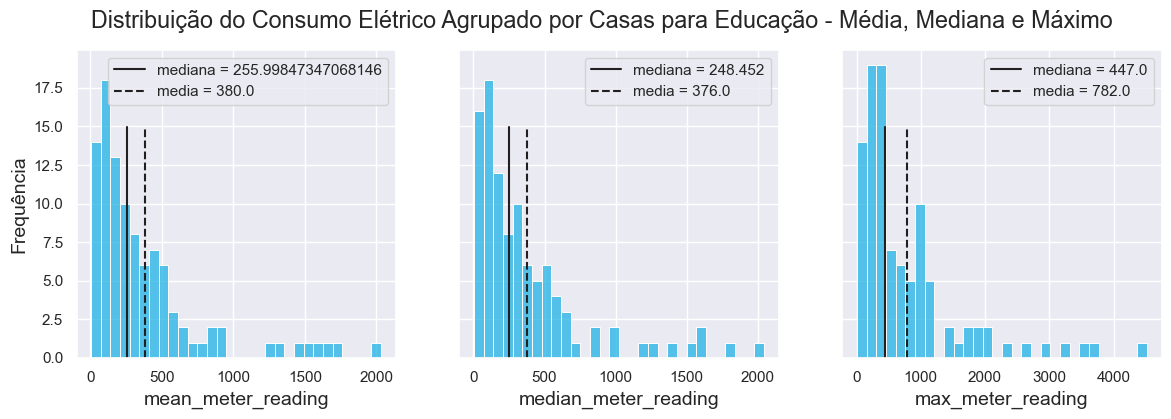

In [24]:
df_train_grouped_education = (
    df_train
        .loc[df_train['meter_reading'] > 0]
        .groupby('building_id')
        ['meter_reading']
        .agg([
            'mean',
            'median',
            'max'
        ])
        .rename({
            'mean':'mean_meter_reading',
            'median':'median_meter_reading',
            'max':'max_meter_reading'
        }, axis = 1)
        .reset_index()
    )

plota_histograma(
    ['mean_meter_reading', 'median_meter_reading', 'max_meter_reading'],
    df_train_grouped_education, 
    1,
    3,
    'Distribuição do Consumo Elétrico Agrupado por Casas para Educação - Média, Mediana e Máximo'
) 

> 1. Nesta nova visão, como estamos avaliando o consumo elétrico de 101 casas, o intuito é analisar de forma individual cada casa. Para isso, agrupou-se o consumo em relação a algumas estatísticas descritivas.

> 2. A princípio nota-se que a presença de uma distribuição assimétrica para a direita em relaçao as medições em relação a média, mediana e máximo; logo, conclui-se que a grande parte das casas de fato aparenta não ter um alto gasto de energia, embora haja outliers que tem alto consumo.

> 3. Em relação a média do consumo, ela é influcianda por outliers, levando os números para baixo e para cima; em relação a mediana do consumo, uma estatística inerente aos outliers, pode-se ter uma visão um pouco mais fidedigna; em relação máximo consumo, é possível notar situações as quais o consumo foi elevado por algum motivo em questão.



### B) As variáveis quantitativas possuem correlação com a Target?

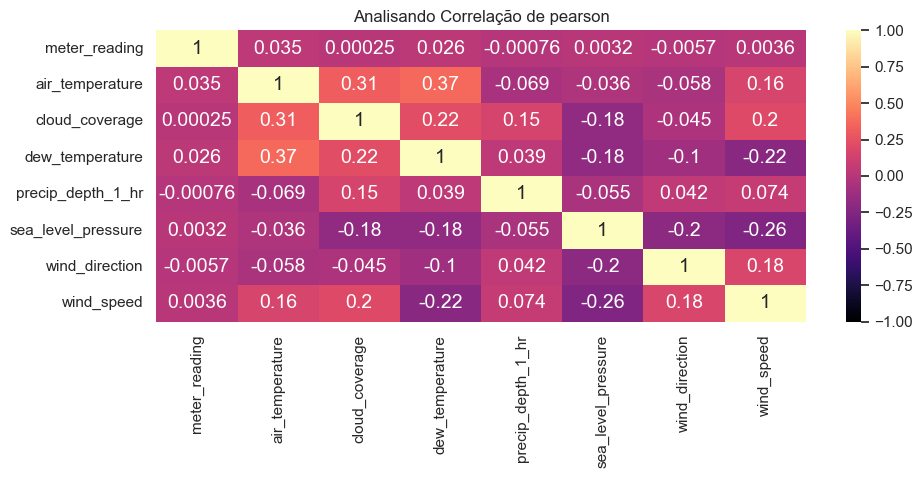

In [25]:
analisa_correlacao('pearson', df_train.loc[df_train['meter_reading'] > 0][['meter_reading', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed']])

> 1. Através da Tabela de Correlação de Pearson, notou-se que nenhuma variável tem correlação linear forte com a target, nem entre elas

## 2.3) Análise Univariada e Bivariada - Variáveis Qualitativas

### A) Como é a Distribuição em relação ao segmento de uso das residências?

['Education' 'Lodging/residential' 'Office'
 'Entertainment/public assembly' 'Other' 'Retail' 'Parking']


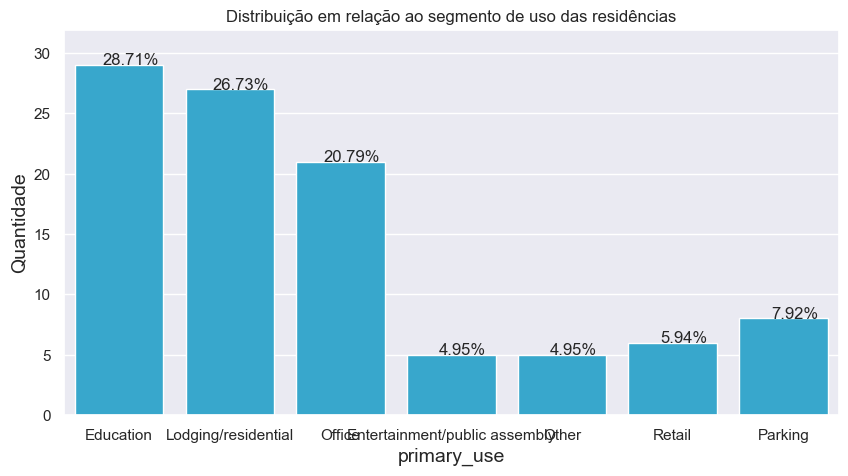

In [26]:
df_train_building = (
    df_train
        .groupby('building_id', as_index = False)
        ['meter_reading']
        .max()
    )

df_train_primary_use = (
    df_train[['building_id', 'primary_use']].drop_duplicates()
    )
    
df_primary_use = df_train_building.merge(df_train_primary_use, on = 'building_id', how = 'left')

print(df_primary_use['primary_use'].unique())
plota_barras(['primary_use'], False, df_primary_use, 1, 1, 'Distribuição em relação ao segmento de uso das residências')

> 1. Nota-se que a grande maioria das residências pertence aos segmentos educacionais, residenciais ou laborais, corroborando com a realidade 

### B) O valor de consumo elétrico é significativamente diferente para cada tipo de segmento?

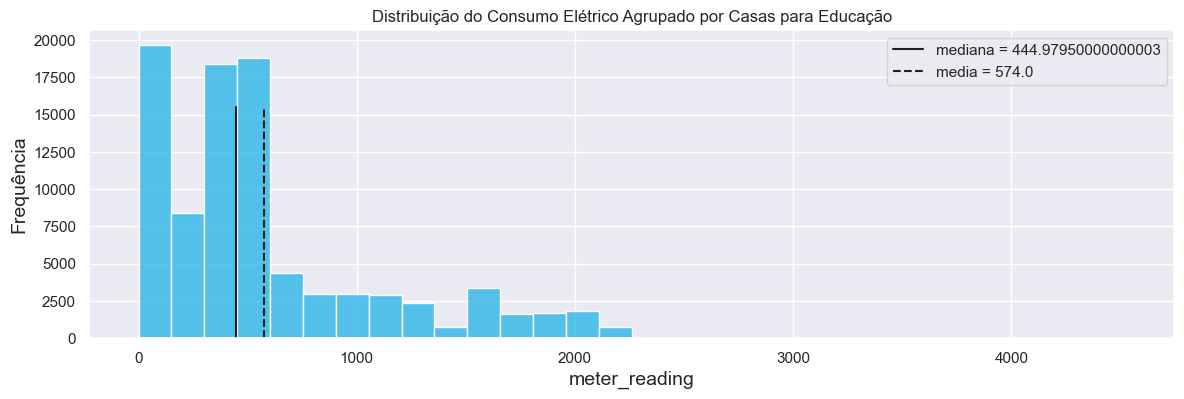

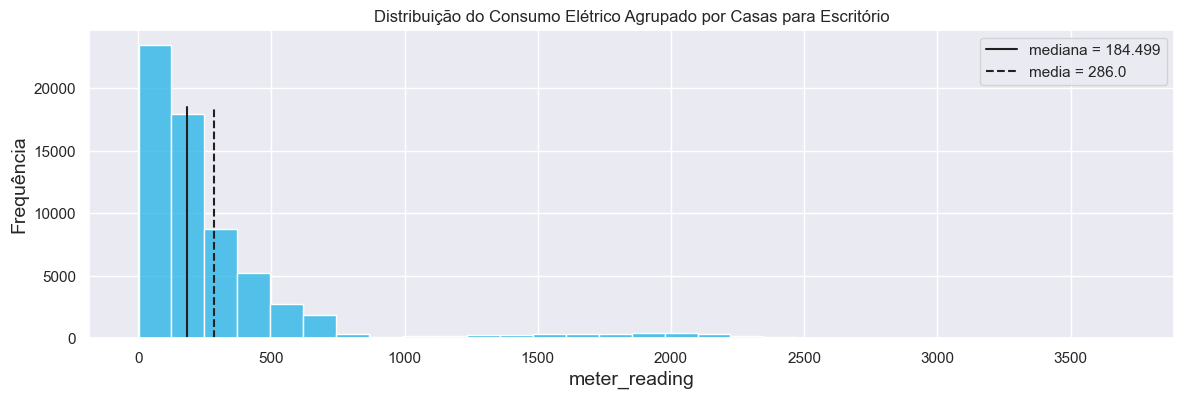

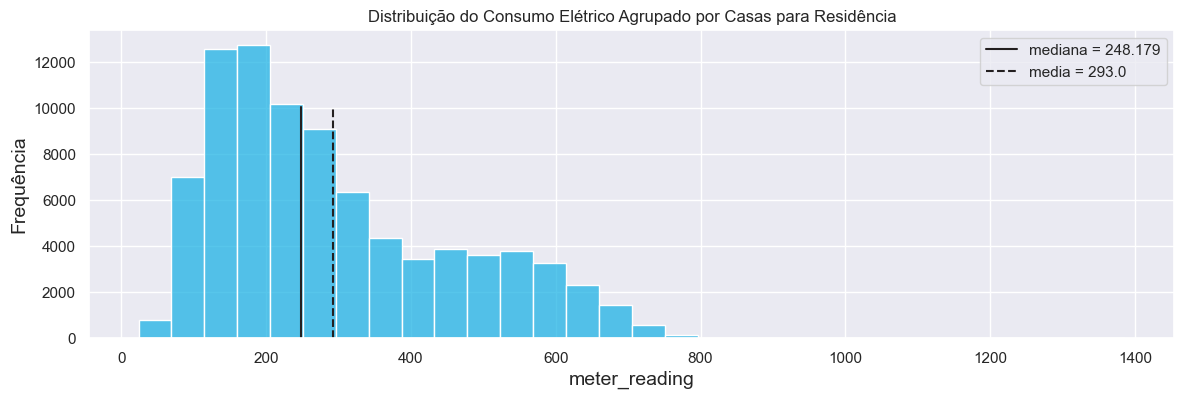

Teste de Hipótese Education vs Office

Mediana Amostra 1: 444.97950000000003
Mediana Amostra 2: 184.499
Pelo Teste de Hipótese de Mann Whitney, há diferença significativa entre as medianas da Amostra 1 e Amostra 2

Teste de Hipótese Education vs Residential

Mediana Amostra 1: 444.97950000000003
Mediana Amostra 2: 248.179
Pelo Teste de Hipótese de Mann Whitney, há diferença significativa entre as medianas da Amostra 1 e Amostra 2

Teste de Hipótese Office vs Residential

Mediana Amostra 1: 184.499
Mediana Amostra 2: 248.179
Pelo Teste de Hipótese de Mann Whitney, há diferença significativa entre as medianas da Amostra 1 e Amostra 2


In [27]:
df_train_grouped_education = df_train.loc[(df_train.meter_reading > 0) & (df_train.primary_use == 'Education')]
df_train_grouped_office = df_train.loc[(df_train.meter_reading > 0) & (df_train.primary_use == 'Office')]
df_train_grouped_residential = df_train.loc[(df_train.meter_reading > 0) & (df_train.primary_use == 'Lodging/residential')]

# Análise Gráfica
plota_histograma(['meter_reading'],df_train_grouped_education,1,1,'Distribuição do Consumo Elétrico Agrupado por Casas para Educação') 
plota_histograma(['meter_reading'],df_train_grouped_office,1,1,'Distribuição do Consumo Elétrico Agrupado por Casas para Escritório') 
plota_histograma(['meter_reading'],df_train_grouped_residential,1,1,'Distribuição do Consumo Elétrico Agrupado por Casas para Residência') 

# Análise Estatística

print('Teste de Hipótese Education vs Office')
print()
teste_hipotese_duas_amostras_independentes(False, df_train_grouped_education, df_train_grouped_office, 'meter_reading')
print()
print('Teste de Hipótese Education vs Residential')
print()
teste_hipotese_duas_amostras_independentes(False, df_train_grouped_education, df_train_grouped_residential, 'meter_reading')
print()
print('Teste de Hipótese Office vs Residential')
print()
teste_hipotese_duas_amostras_independentes(False, df_train_grouped_office, df_train_grouped_residential, 'meter_reading')

> 1. Escolheu-se as três categorias de segmentos com maior representatividade: Educação, Residencial e Escritório 

> 2. Por seguirem distribuições não-paramétricas, realizou-se um Teste de Hipótese de Man Whitneyu para comprovar se a diferença entre as medianas das amostras eram significativas ou não 

> 3. Tanto grafricamente quanto estatísticamente, há diferença significativa

### C) Como é a Distribuição em Relação ao Ano de Construção? 

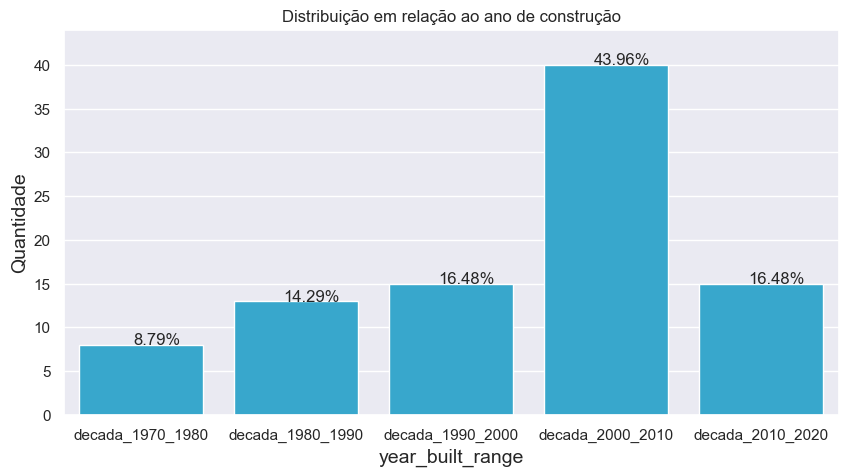

In [28]:
df_train_building = (
    df_train
        .groupby('building_id', as_index = False)
        ['meter_reading']
        .max()
    )
    
df_train_year_built = (
    df_train[['building_id', 'year_built']].drop_duplicates()
    )

df_year_built = (df_train_building.merge(df_train_year_built, on = 'building_id', how = 'left'))
df_year_built['year_built_range'] = pd.cut(
    df_year_built['year_built'], 
    bins=[1970, 1980, 1990, 2000, 2010, 2020], 
    labels=['decada_1970_1980', 'decada_1980_1990', 'decada_1990_2000', 'decada_2000_2010', 'decada_2010_2020'], 
    right=False
    )

plota_barras(['year_built_range'], False, df_year_built, 1, 1, 'Distribuição em relação ao ano de construção')

> 1. A maioria das casas foi construída após 1980, com destaque para os anos entre 2000 e 2010

### D) O valor de consumo elétrico é significativamente diferente para cada década?

In [29]:
def teste_hipotese_muitas_amostras_independentes(amostras, variavel):
    medianas = []
    
    for i, amostra in enumerate(amostras):
        mediana_amostra = amostra[variavel].median()
        medianas.append(mediana_amostra)
        print(f'Mediana Amostra {i+1}: {mediana_amostra}')

    stat, p_value = kruskal(*[amostra[variavel] for amostra in amostras])
    
    if p_value > 0.05:
        print(f'Pelo teste de Kruskal-Wallis, não há diferença significativa entre as medianas das amostras')
    else:
        print(f'Pelo teste de Kruskal-Wallis, há diferença significativa entre as medianas das amostras')


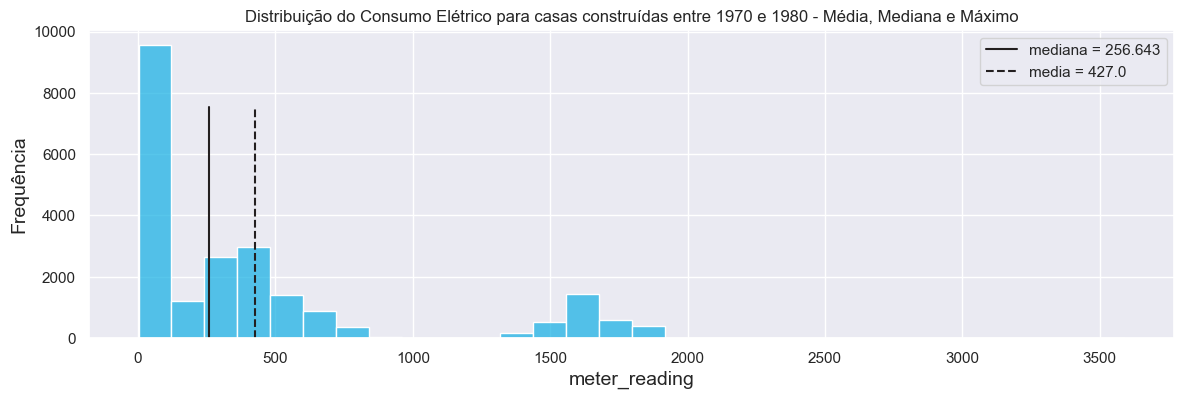

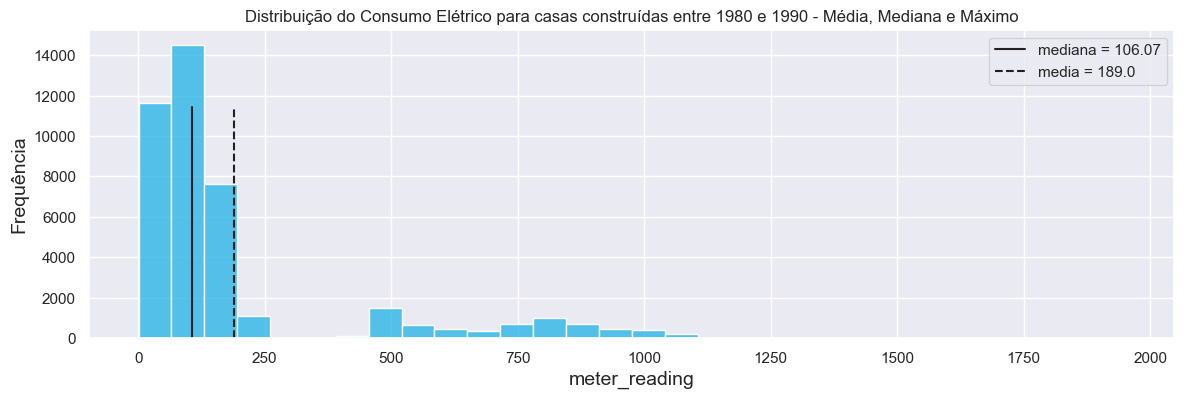

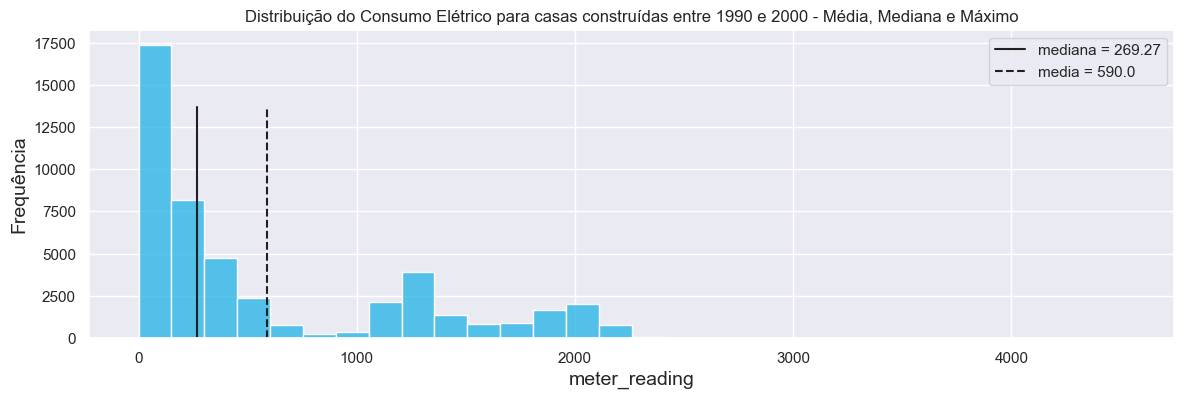

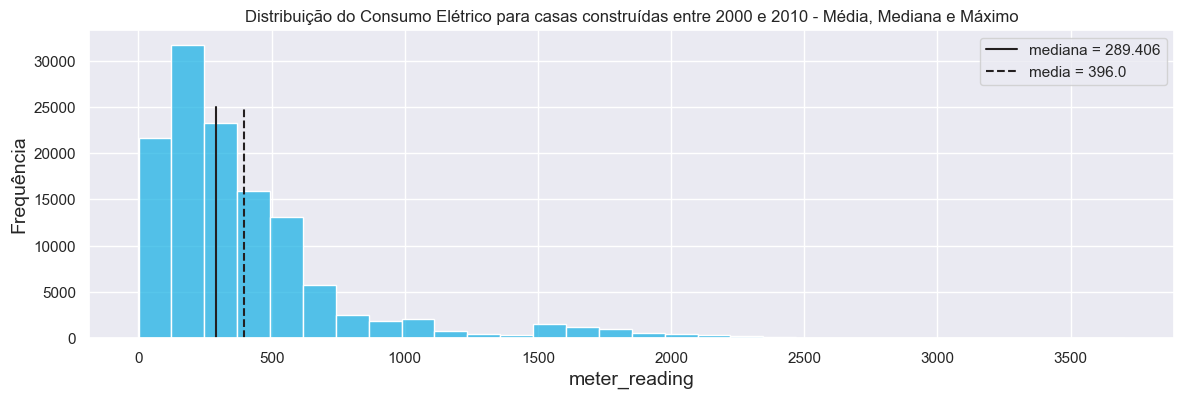

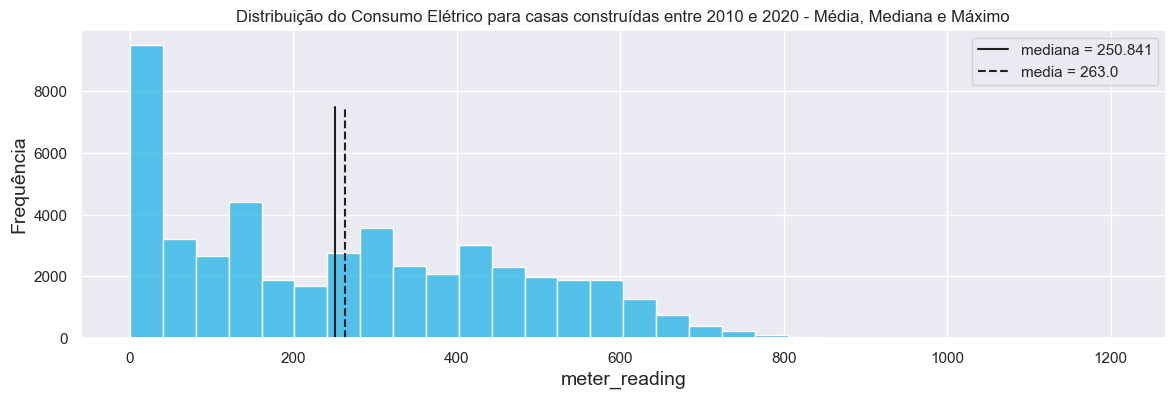

Mediana Amostra 1: 256.643
Mediana Amostra 2: 106.07
Mediana Amostra 3: 269.27
Mediana Amostra 4: 289.406
Mediana Amostra 5: 250.841
Pelo teste de Kruskal-Wallis, há diferença significativa entre as medianas das amostras


In [30]:
df_train['year_built_range'] = pd.cut(
    df_train['year_built'], 
    bins=[1970, 1980, 1990, 2000, 2010, 2020], 
    labels=['decada_1970_1980', 'decada_1980_1990', 'decada_1990_2000', 'decada_2000_2010', 'decada_2010_2020'], 
    right=False
    )

df_train_grouped_decada_1970_1980 = df_train.loc[(df_train.meter_reading > 0) & (df_train.year_built_range == 'decada_1970_1980')]
df_train_grouped_decada_1980_1990 = df_train.loc[(df_train.meter_reading > 0) & (df_train.year_built_range == 'decada_1980_1990')]
df_train_grouped_decada_1990_2000 = df_train.loc[(df_train.meter_reading > 0) & (df_train.year_built_range == 'decada_1990_2000')]
df_train_grouped_decada_2000_2010 = df_train.loc[(df_train.meter_reading > 0) & (df_train.year_built_range == 'decada_2000_2010')]
df_train_grouped_decada_2010_2020 = df_train.loc[(df_train.meter_reading > 0) & (df_train.year_built_range == 'decada_2010_2020')]

# Análise Gráfica
plota_histograma(['meter_reading'],df_train_grouped_decada_1970_1980,1,1,'Distribuição do Consumo Elétrico para casas construídas entre 1970 e 1980 - Média, Mediana e Máximo') 
plota_histograma(['meter_reading'],df_train_grouped_decada_1980_1990,1,1,'Distribuição do Consumo Elétrico para casas construídas entre 1980 e 1990 - Média, Mediana e Máximo') 
plota_histograma(['meter_reading'],df_train_grouped_decada_1990_2000,1,1,'Distribuição do Consumo Elétrico para casas construídas entre 1990 e 2000 - Média, Mediana e Máximo') 
plota_histograma(['meter_reading'],df_train_grouped_decada_2000_2010,1,1,'Distribuição do Consumo Elétrico para casas construídas entre 2000 e 2010 - Média, Mediana e Máximo') 
plota_histograma(['meter_reading'],df_train_grouped_decada_2010_2020,1,1,'Distribuição do Consumo Elétrico para casas construídas entre 2010 e 2020 - Média, Mediana e Máximo') 

# Análise Estatística

teste_hipotese_muitas_amostras_independentes(
    [df_train_grouped_decada_1970_1980, df_train_grouped_decada_1980_1990, df_train_grouped_decada_1990_2000, df_train_grouped_decada_2000_2010, df_train_grouped_decada_2010_2020], 
    'meter_reading')

> 1. Graficamente e estatisticamente, há diferença entre o consumo de energia elétrica em relação ao ano de construção da casa 

## 2.4) Análise Univariada e Bivariada - Variáveis Temporais

### A) Como é o Consumo Elétrico Médio na visão: Diária e Mensal?

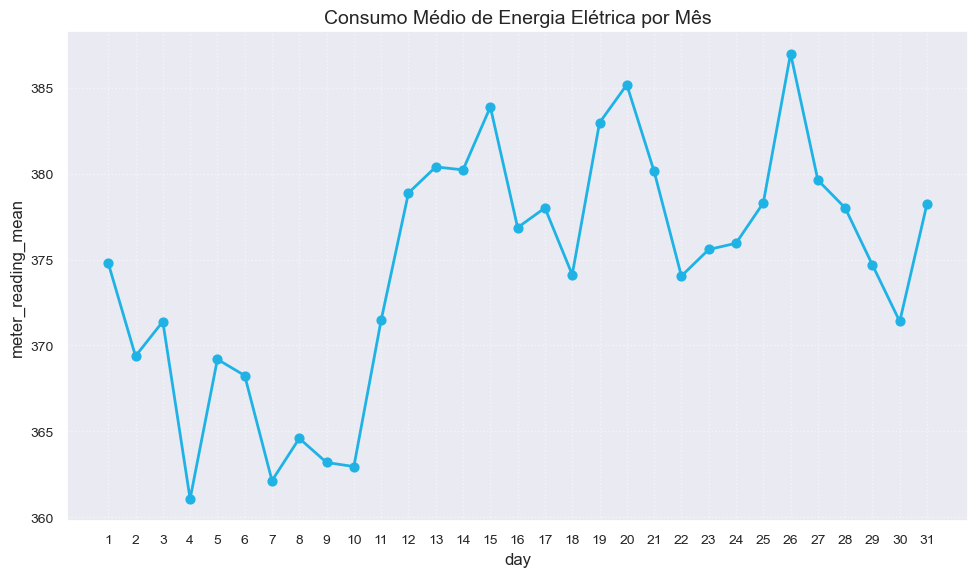

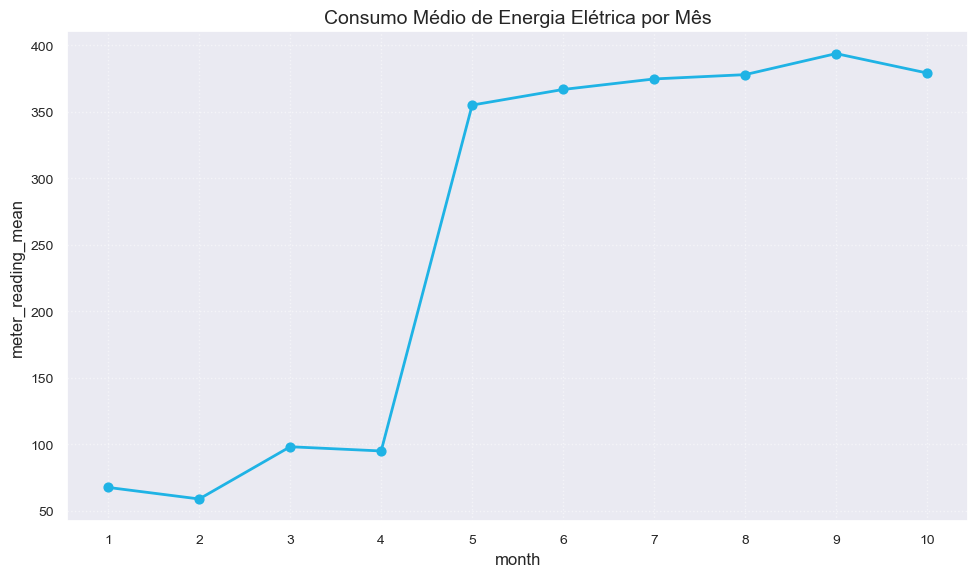

In [32]:
df_train_time_series = df_train.loc[df_train['meter_reading'] > 0][['meter_reading', 'day']]
df_train_time_series = df_train_time_series.groupby('day')['meter_reading'].mean()
plota_temporal(df_train_time_series, 'Consumo Médio de Energia Elétrica por Mês', 'day', 'meter_reading_mean')

df_train_time_series = df_train.loc[df_train['meter_reading'] > 0][['meter_reading', 'month']]
df_train_time_series = df_train_time_series.groupby('month')['meter_reading'].mean()
plota_temporal(df_train_time_series, 'Consumo Médio de Energia Elétrica por Mês', 'month', 'meter_reading_mean')

> 1. Na visão consumo médio diário, nota-se que o consumo tende a aumentar após o dia 10

> 2. Na visão consumo médio mensal, percebe-se que a partir de Maio o consumo aumenta consideravelmente

# <font color='red' style='font-size: 40px;'> 3.0 Feature Engineer </font>
<hr style='border: 2px solid red;'>

# <font color='red' style='font-size: 40px;'> 4.0 Aplicação de Modelos de Machine Learning </font>
<hr style='border: 2px solid red;'>

# <font color='red' style='font-size: 40px;'> 5.0 Consolidação dos Resultados </font>
<hr style='border: 2px solid red;'>